In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

## 1. Data generation

Create a function for generating the data. Both the input u (noisy stimulus) and the target output y (identity of the stimulus) are one-dimensional. The input $u(t) \in \mathbb{R}^1$  is defined by:

$
u(t) = 
\begin{cases}
\bar{u} + \xi(t), & \text{if } 5 \le t \le 45 \\
\xi(t), & \text{otherwise}
\end{cases}
$ 

$\bar{u}$ is the stimulus strength, drawn uniformly from $\pm \frac{3.2}{100} ({1, 2, 4, 8, 16})$, and $\xi$ is background noise, drawn from a normal distribution with mean 0 and standard-deviation 0.03.

The stimulus strength is re-sampled for each trial, the noise is re-sampled for each time-step. The target y is defined as the sign of $\bar{u}$. Write your function such that it can generate multiple trials at the same time, this will be useful for training our network using stochastic gradient descent. Plot the data for several trials to make sure the labels match the inputs, and the noise levels are reasonable.

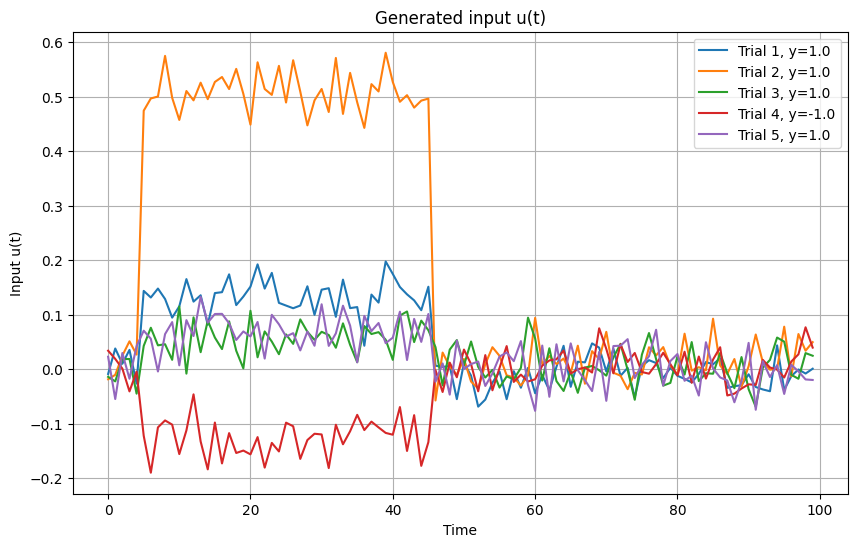

In [2]:
def create_input_data(time, noise_mean=0, noise_std=0.03):
    u = np.zeros(len(time))
    # stimulus strength, drawn uniformly from $\pm \frac{3.2}{100} {1, 2, 4, 8, 16}$
    positive_magnitudes = (3.2 / 100) * np.array([1, 2, 4, 8, 16])
    possible_stimulus_strengths = np.sort(np.concatenate([-positive_magnitudes, positive_magnitudes]))
    stimulus_strength = np.random.choice(possible_stimulus_strengths)
    for t in time:
        xi = np.random.normal(noise_mean, noise_std)
        # if t smaller equal 45, bigger equal 5
        if 5 <= t <= 45:
            u[t] = stimulus_strength + xi
        else:
            u[t] = xi
    y = np.sign(stimulus_strength)
    return u, y

def create_input_dataframe_multiple_trials(time, trials=100):
    data = []
    for _ in range(trials):
        u, y = create_input_data(time)
        data.append({'u': u, 'y': y})
    df = pd.DataFrame(data)
    return df

t = np.arange(0, 100)
input = create_input_dataframe_multiple_trials(t, trials=5)


plt.figure(figsize=(10, 6))
for i in range(len(input)):
    plt.plot(t, input['u'][i], label=f'Trial {i+1}, y={input["y"][i]}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Generated input u(t)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Recurrent Neural Network Initialization

Implement the recurrent neural network in your favorite deep learning library. The network has one-dimensional inputs and outputs, and an arbitrary number N of recurrent units. Its trainable parameters are the left and right connectivity vectors m, n. It also has fixed input and output weights I and w, respectively. All (trainable and fixed) parameters are sampled from a standard normal distribution, with the exception of the output weights, which are drawn with standard deviation of 4 (why?). The dynamics of the ith unit are given by

$
\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t), \quad i = 1, \ldots, N.
$

Here $\Phi= \tanh$ is the neuron’s transfer function, and $\tau = 100$ ms the neuronal time constant. Simulate the network using forward Euler with a time step of $\Delta t = 20$ ms (the stimulus duration of 75 time steps corresponds to 1500ms real time). The rank one matrix J is defined as

$
J = \frac{1}{N}\, \mathbf{m} \mathbf{n}^T
$

The network’s output is a linear readout of the rates:

$
z(t) = \frac{1}{N} \sum_{i=1}^N w_i \Phi(x_i)
$

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device(
    'cuda' if torch.cuda.is_available() else 
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)

class RankOneRNN(nn.Module):
    def __init__(self, N):
        super(RankOneRNN, self).__init__()
        self.N = N
        self.m = nn.Parameter(torch.randn(self.N, 1).to(device))
        self.n = nn.Parameter(torch.randn(self.N, 1).to(device))
        self.I = torch.randn(N).to(device)  
        self.w = torch.randn(N).to(device) * 4  # std=4

        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):  # u_batch: (B, T)
        B, T = u_batch.shape
        x = torch.zeros(B, self.N).to(device)  # initial hidden state
        z_out = []

        for t in range(T):
            phi_x = torch.tanh(x)  # (B, N)
            J_phi = (1 / self.N) * (phi_x @ self.n) * self.m.T  # rank-1
            u_t = u_batch[:, t]  # (B,)
            du = (-x + J_phi + self.I * u_t.unsqueeze(1)) * (self.dt / self.tau)
            x = x + du
            z_t = (1 / self.N) * (phi_x @ self.w)  # (B,)
            z_out.append(z_t)

        z_out = torch.stack(z_out, dim=1)  # shape: (B, T)
        return z_out

## 3. Training the network

Train a network of size N = 1281 by minimizing the mean squared error

$
\frac{1}{BT} \sum_{i, t} (z_i(t) - y_i(t))^2
$

using stochastic gradient descent. Here, the sum runs over all B trials in a mini-batch and the last T = 15 time steps (the target is only defined during this last ’decision epoch’). Use Adam with a learning rate of 5e-3 and a batch size of 32. The loss should converge to a value below 5e-2, which might require 1000 parameter updates. If the loss converges to higher values, debug your code by (1) overfitting the network on a single batch, and (2) training a full-rank network. Make sure to look at the the network’s input, output, and hidden dynamics once it has successfully converged.



In [4]:
def get_batch(time, batch_size):
    df = create_input_dataframe_multiple_trials(time, trials=batch_size)
    u = np.stack(df['u'].values)  # (B, T)
    y = np.array(df['y'].values)  # (B,)
    return torch.tensor(u, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

N = 1000
batch_size = 32
lr = 5e-3
loss_threshold = 5e-2
T_total = 100
T_decision = 15
num_updates = 1000

model = RankOneRNN(N).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

losses = []
for step in range(num_updates):
    u_batch, y_batch = get_batch(np.arange(0, T_total), batch_size)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

    z_batch = model(u_batch)  # shape: (B, T)
    z_decision = z_batch[:, -T_decision:]  # (B, T_decision)
    y_expanded = y_batch.unsqueeze(1).expand_as(z_decision)  # (B, T_decision)

    loss = loss_fn(z_decision, y_expanded)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    losses.append(loss_val)
    
    if loss_val < loss_threshold:
        print(f"Early stopping at step {step}, Loss: {loss_val:.4f}")
        break

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss_val:.4f}")

Step 0, Loss: 1.0000
Step 100, Loss: 1.0000
Early stopping at step 174, Loss: 0.0498


## 4. Analysis of the network

We now have a neural network model that performs perceptual decision-making, but this is only a first step. Next, we want to understand how this model works, to generate
hypotheses how the brain might perform analogous functions. Dubreuil et al.[3] found that their network relied on a specific pattern of correlations between the connectivity vectors (their figure 2b). Explain why this pattern works for the task, and compare it
with the pattern in your network.


Correlation between m and n: 0.7325


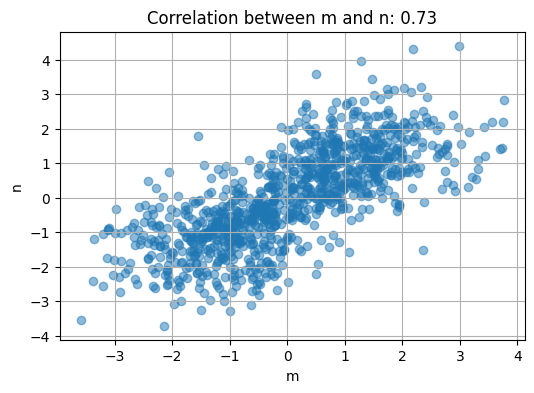

In [5]:
# Analysis of the pattern of correlations between connectivity vectors m, n

# Compute and plot the correlation between m and n
m_np = model.m.detach().cpu().numpy().flatten()
n_np = model.n.detach().cpu().numpy().flatten()

correlation = np.corrcoef(m_np, n_np)[0, 1]
print(f"Correlation between m and n: {correlation:.4f}")

plt.figure(figsize=(6, 4))
plt.scatter(m_np, n_np, alpha=0.5)
plt.xlabel('m')
plt.ylabel('n')
plt.title(f'Correlation between m and n: {correlation:.2f}')
plt.grid(True)
plt.show()

## 5. Gaussian approximation

The theory of low-rank networks relies on Gaussian approximations (see methods and supplements of [3]), which characterizes connectivity vectors by their second order statistics. Test if this assumption holds in your trained network by (1) fitting a 4-dimensional Gaussian distribution to the connectivity vectors, (2) Resampling from the fitted distribution, (3) Comparing the empirical with the resampled distribution, and (4) Testing networks with the resampled connectivity by comparing the sign of the output with the sign of the target.

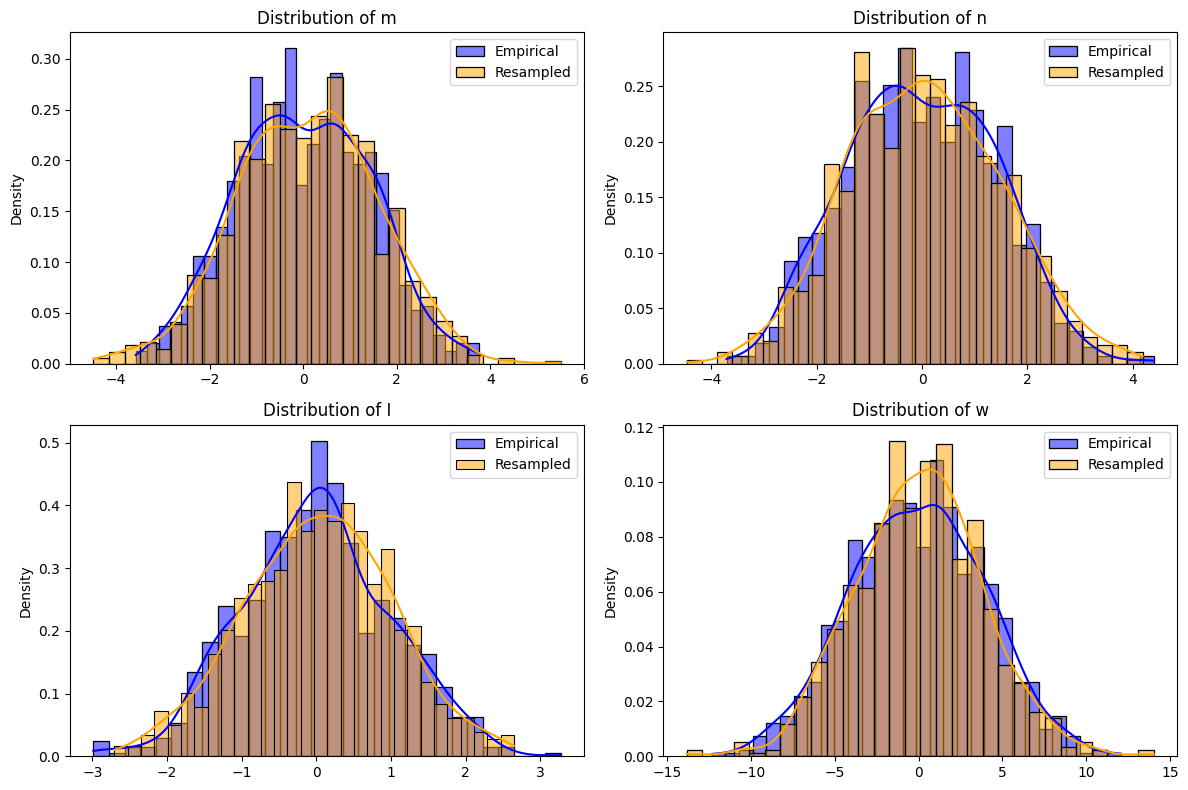

Classification accuracy (resampled connectivity): 100.00%


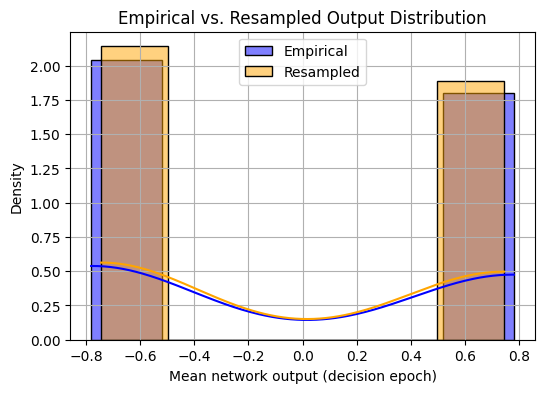

In [6]:
import seaborn as sns

param_names = ['m', 'n', 'I', 'w']
params = [
    getattr(model, name).detach().cpu().numpy().flatten() 
    for name in param_names
]
X = np.stack(params, axis=1)  # shape (N, 4)

mean = X.mean(axis=0)
cov = np.cov(X, rowvar=False)

z_decision_np = z_decision.detach().cpu().numpy()  # (B, T_decision)
y_expanded_np = y_expanded.detach().cpu().numpy()  # (B, T_decision)
mean_z = z_decision_np.mean(axis=1)       # (B,)
target_sign = y_expanded_np[:, 0]         # (B,)

# 2. Resample from the fitted distribution
N = X.shape[0]
X_resampled = np.random.multivariate_normal(mean, cov, size=N)
m_resampled, n_resampled, I_resampled, w_resampled = [X_resampled[:, i] for i in range(4)]

# 3. Compare empirical and resampled distributions
plt.figure(figsize=(12, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 2, i+1)
    sns.histplot(X[:, i], color='blue', label='Empirical', kde=True, stat='density', bins=30)
    sns.histplot(X_resampled[:, i], color='orange', label='Resampled', kde=True, stat='density', bins=30, alpha=0.5)
    plt.title(f'Distribution of {name}')
    plt.legend()
plt.tight_layout()
plt.show()

# 4. Test network with resampled connectivity
model_gauss = RankOneRNN(N).to(device)
model_gauss.m = nn.Parameter(torch.tensor(m_resampled, dtype=torch.float32, device=device).unsqueeze(1))
model_gauss.n = nn.Parameter(torch.tensor(n_resampled, dtype=torch.float32, device=device).unsqueeze(1))
model_gauss.I = torch.tensor(I_resampled, dtype=torch.float32, device=device)
model_gauss.w = torch.tensor(w_resampled, dtype=torch.float32, device=device)

# Use the same batch as before for fair comparison
with torch.no_grad():
    z_batch_gauss = model_gauss(u_batch)
    z_decision_gauss = z_batch_gauss[:, -z_decision_np.shape[1]:].cpu().numpy()
    mean_z_gauss = z_decision_gauss.mean(axis=1)
    pred_sign_gauss = np.sign(mean_z_gauss)
    accuracy_gauss = np.mean(pred_sign_gauss == target_sign)
    print(f"Classification accuracy (resampled connectivity): {accuracy_gauss:.2%}")

# Compare output distributions
plt.figure(figsize=(6, 4))
sns.histplot(mean_z, color='blue', label='Empirical', kde=True, stat='density')
sns.histplot(mean_z_gauss, color='orange', label='Resampled', kde=True, stat='density', alpha=0.5)
plt.xlabel('Mean network output (decision epoch)')
plt.title('Empirical vs. Resampled Output Distribution')
plt.legend()
plt.grid(True)
plt.show()

## 6. Dimensionality reduction

The dynamics of our model are low-dimensional, making dimensionality reduction [2] a promising approach. In this case, we already know the 2-dimensional space in which the dynamics live: it is spanned by the input vector I and the left-connectivity vector m (why?). Confirm this by projecting the N dimensional, time-varying dynamics x(t) onto the m −I plane. Do the dynamics of different trials evolve in an interpretable manner? How could you reduce the dimensionality if you did not know m and I, as would be the case with an arbitrary RNN, or with experimental data?


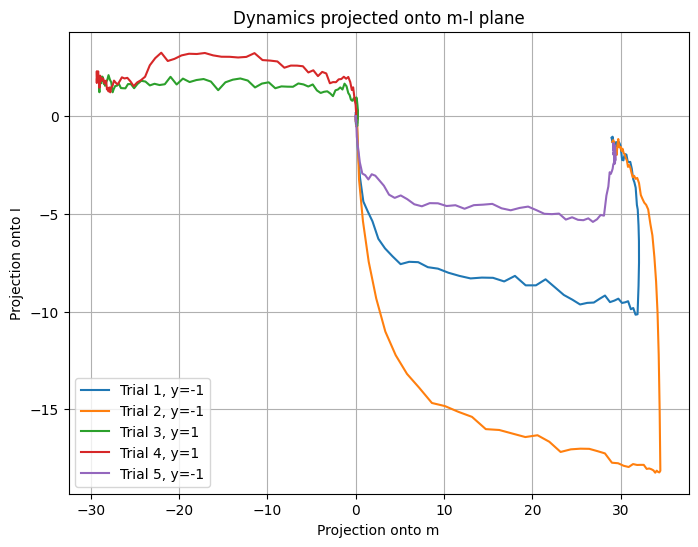

In [7]:
# Project the hidden state dynamics x(t) onto the m-I plane for several trials

# 1. Collect hidden states x(t) for several trials
num_trials = 5
T_total = 100

# Generate a batch of inputs and run the model to collect hidden states
u_batch, y_batch = get_batch(np.arange(0, T_total), num_trials)
u_batch = u_batch.to(device)

# We'll modify the model's forward pass to return hidden states for analysis
def get_hidden_states(model, u_batch):
    B, T = u_batch.shape
    x = torch.zeros(B, model.N).to(device)
    xs = []
    for t in range(T):
        phi_x = torch.tanh(x)
        J_phi = (1 / model.N) * (phi_x @ model.n) * model.m.T
        u_t = u_batch[:, t]
        du = (-x + J_phi + model.I * u_t.unsqueeze(1)) * (model.dt / model.tau)
        x = x + du
        xs.append(x.detach().cpu().numpy())
    xs = np.stack(xs, axis=1)  # (B, T, N)
    return xs

xs = get_hidden_states(model, u_batch)  # shape: (B, T, N)

# 2. Project onto m and I
m_np = model.m.detach().cpu().numpy().flatten()
I_np = model.I.detach().cpu().numpy().flatten()
m_norm = m_np / np.linalg.norm(m_np)
I_norm = I_np / np.linalg.norm(I_np)

proj_m = np.dot(xs, m_norm)  # (B, T)
proj_I = np.dot(xs, I_norm)  # (B, T)

# 3. Plot the trajectories in the m-I plane
plt.figure(figsize=(8, 6))
for i in range(num_trials):
    plt.plot(proj_m[i], proj_I[i], label=f'Trial {i+1}, y={y_batch[i].item():.0f}')
plt.xlabel('Projection onto m')
plt.ylabel('Projection onto I')
plt.title('Dynamics projected onto m-I plane')
plt.legend()
plt.grid(True)
plt.show()

## 7. Distill trained model

Using the Gaussian assumption, we are ready for the final step: distilling the trained network into an equivalent one-dimensional dynamical system of the form

$$
\tau \frac{d\kappa}{dt} = -\kappa(t) + \tilde{\sigma}_{mn} \kappa(t) + \tilde{\sigma}_{nI} v(t),
$$

where $\kappa$ is the latent variable $\kappa(t) = \frac{1}{\|\mathbf{m}\|} \mathbf{m}^T \mathbf{x}(t)$ and $v$ the external inputs filtered by the neuronal time constant:

$$
\tau \frac{dv}{dt} = -v(t) + u(t).
$$

Note that these equations assume that $\mathbf{m}$ and $\mathbf{I}$ are orthogonal. Each coupling term $\tilde{\sigma}_{ab}$ is the product $\sigma_{ab} \langle \Phi' \rangle(\Delta)$ of the corresponding covariance and the neuronal gain, averaged over the Gaussian statistics of the population:

$$
\langle \Phi' \rangle(\Delta) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \phi'(\Delta z) e^{-z^2/2} dz.
$$

Here, $\Delta$ captures the system’s non-linearity because it depends on the state $\kappa$ and inputs $v$:

$$
\Delta = \sqrt{\sigma_m^2 \kappa^2 + \sigma_I^2 u^2}.
$$
First, compute the necessary covariances $\sigma_{mn}$, $\sigma_{nI}$ etc. from your trained network. Then, use these to simulate the low-dimensional dynamics $\frac{d\kappa}{dt}$. You can use scipy’s quadrature function to integrate the Gaussian integral. Does the equivalent circuit indeed perform the task? If it does not, try using the covariances given in the paper: $\sigma_{mn} = 1.4$, $\sigma_{nI} = 2.6$, $\sigma_{mw} = 2.1$, and $\sigma_{w} = \sigma_{n} = \sigma_{I} = 1$.


Low-dimensional circuit accuracy: 100.00%


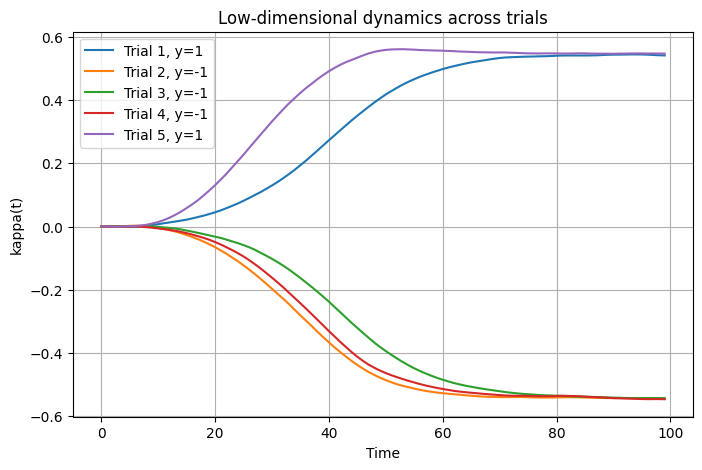

In [17]:
from scipy import integrate

# 1. Compute covariances from trained network
params = [
    getattr(model, name).detach().cpu().numpy().flatten() 
    for name in param_names
]
m_np = params[0]
n_np = params[1]
I_np = params[2]
w_np = params[3]

sigma_m = np.std(m_np)
sigma_n = np.std(n_np)
sigma_I = np.std(I_np)
sigma_w = np.std(w_np)
sigma_mn = np.cov(m_np, n_np)[0, 1]
sigma_nI = np.cov(n_np, I_np)[0, 1]
sigma_mw = np.cov(m_np, w_np)[0, 1]

# 2. Define <phi'> as a function of Delta
def phi_prime(z):
    return 1 - np.tanh(z)**2

def mean_phi_prime(Delta):
    # <phi'> = E[phi'(Delta * z)], z~N(0,1)
    integrand = lambda z: phi_prime(Delta * z) * np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)
    val, _ = integrate.quad(integrand, -8, 8)
    return val

# 3. Simulate the low-dimensional system
def simulate_low_dim(u, dt=20, tau=100, kappa0=0, v0=0):
    T = len(u)
    kappa = np.zeros(T)
    v = np.zeros(T)
    kappa[0] = kappa0
    v[0] = v0
    for t in range(1, T):
        # Filtered input
        dv = (-v[t-1] + u[t-1]) * (dt / tau)
        v[t] = v[t-1] + dv

        # Nonlinearity
        Delta = np.sqrt(sigma_m**2 * kappa[t-1]**2 + sigma_I**2 * u[t-1]**2)
        gain = mean_phi_prime(Delta)

        # Couplings
        sigma_mn_eff = sigma_mn * gain
        sigma_nI_eff = sigma_nI * gain

        # Low-dim dynamics
        dkappa = (-kappa[t-1] + sigma_mn_eff * kappa[t-1] + sigma_nI_eff * v[t-1]) * (dt / tau)
        kappa[t] = kappa[t-1] + dkappa
    return -kappa, v

# 4. Test on a batch of trials
num_trials = 5
T_total = 100
u_batch, y_batch = get_batch(np.arange(0, T_total), num_trials)
u_batch_np = u_batch.cpu().numpy()

kappa_all = []
for i in range(num_trials):
    kappa, v = simulate_low_dim(u_batch_np[i])
    kappa_all.append(kappa)

kappa_all = np.stack(kappa_all)  # (num_trials, T_total)

# 5. Decision: sign of mean kappa in decision epoch
T_decision = 15
mean_kappa = kappa_all[:, -T_decision:].mean(axis=1)
pred_sign = np.sign(mean_kappa)
target_sign = y_batch.cpu().numpy()
accuracy = np.mean(pred_sign == target_sign)
print(f"Low-dimensional circuit accuracy: {accuracy:.2%}")

# 6. Plot example trajectories
plt.figure(figsize=(8, 5))
for i in range(num_trials):
    plt.plot(kappa_all[i], label=f'Trial {i+1}, y={int(target_sign[i])}')
plt.xlabel('Time')
plt.ylabel('kappa(t)')
plt.title('Low-dimensional dynamics across trials')
plt.legend()
plt.grid(True)
plt.show()

## 8. Fixed point analysis

A complementary way of reverse-engineering a trained RNN is to analyze its locally linear dynamics around fixed points [9]. This is a standard approach in low-dimensional systems, done numerically when applied to RNNs. Find the fixed points of the low-dimensional circuit by minimizing the energy $q = \frac{1}{2} \left(\frac{d\kappa}{dt}\right)^2$ over $\kappa$ for zero input (note that this is not the second derivative!). You can use scipy’s `minimize` for this. How would the result change in a circuit that integrates the exact value of its input, rather than the sign?


Fixed point (kappa*): 0.0000


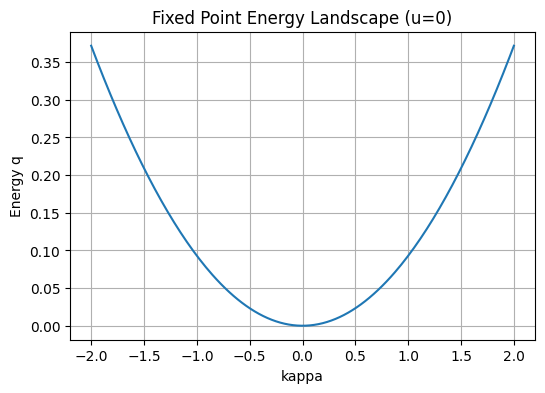

For a perfect integrator, any kappa is a fixed point when input is zero.


In [19]:
from scipy.optimize import minimize

# Fixed point analysis for the low-dimensional circuit (zero input)
# We minimize q = 0.5 * (dkappa/dt)^2 over kappa, with u=0

def fixed_point_energy(kappa, sigma_mn, gain):
    # For zero input, v=0, u=0, so Delta = |sigma_m * kappa|
    dkappa = (-kappa + sigma_mn * gain * kappa)  # dt/tau omitted (irrelevant for fixed point)
    return 0.5 * dkappa**2

# Use the gain at Delta=0 (since u=0, v=0, kappa=0 at fixed point)
Delta0 = 0.0
gain0 = mean_phi_prime(Delta0)

# Use trained network's sigma_mn, or values from the paper if needed
sigma_mn_eff = sigma_mn

# Minimize energy to find fixed points
res = minimize(fixed_point_energy, x0=0.0, args=(sigma_mn_eff, gain0))
kappa_star = res.x[0]
print(f"Fixed point (kappa*): {kappa_star:.4f}")

# Plot the energy landscape
kappa_range = np.linspace(-2, 2, 200)
energy = [fixed_point_energy(k, sigma_mn_eff, gain0) for k in kappa_range]
plt.figure(figsize=(6,4))
plt.plot(kappa_range, energy)
plt.xlabel('kappa')
plt.ylabel('Energy q')
plt.title('Fixed Point Energy Landscape (u=0)')
plt.grid(True)
plt.show()

# Compare with the case where the circuit integrates the exact value of its input
# For a perfect integrator: dkappa/dt = u(t), so at u=0, all kappa are fixed points

print("For a perfect integrator, any kappa is a fixed point when input is zero.")

# 3. Parametric Working Memory

Most computations happen in more than one dimension. Here, we will look at such a computation by modeling parametric working memory (see Figure 3 from Dubreuil et al. [3]). The different steps in this exercise are analogous to those in the first exercise. The goal is to:

1. See how the low rank framework applies to networks with rank two.
2. Get more practice with training and reverse-engineering RNNs without relying on the strict instructions from exercise 1.


## 1. Data Generation

Create a function for generating the data. Both the input $u$ and the target output $y$ are again one-dimensional. The input now consists of a first stimulus, followed by a delay and the second stimulus:

$$
u(t) = 
\begin{cases}
u_1 & \text{if } 5 \leq t \leq 10 \\
u_2 & \text{if } 60 \leq t \leq 70 \\
0 & \text{otherwise}
\end{cases}
$$

The two stimuli are defined as

$$
u_i = \frac{1}{f_{\max} - f_{\min}} \left( f_i - \frac{f_{\max} + f_{\min}}{2} \right), \quad i = 1,2
$$

with $f_i$ sampled uniformly from the set $\{10, 14, 18, 22, 26, 30, 34\}$, and $f_{\min} = 10$, $f_{\max} = 34$ the smallest and largest elements of that set. The target output $y$ is the normalized difference between the stimuli:

$$
y = \frac{f_1 - f_2}{f_{\max} - f_{\min}}
$$

Note: In the paper, they use random delays and more points $f_i$. Discuss how that potentially affects the solution.

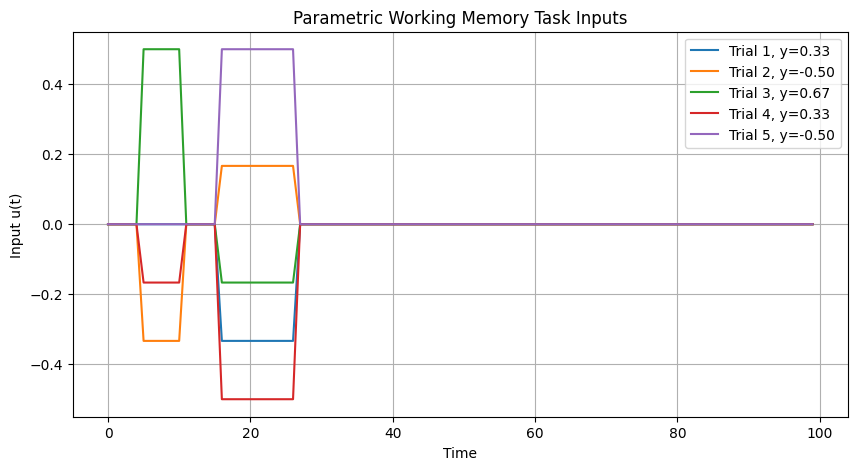

In [48]:
def generate_parametric_memory_trial_with_delay(time, delay):
    freq_set = np.array([10, 14, 18, 22, 26, 30, 34])
    f_min, f_max = freq_set.min(), freq_set.max()
    norm = f_max - f_min
    f1, f2 = np.random.choice(freq_set, size=2, replace=True)
    u1 = (f1 - (f_max + f_min) / 2) / norm
    u2 = (f2 - (f_max + f_min) / 2) / norm

    u = np.zeros(len(time))
    u[(time >= 5) & (time <= 10)] = u1
    stim2_start = 11 + delay
    stim2_end = stim2_start + 10
    u[(time >= stim2_start) & (time <= stim2_end)] = u2

    y = (f1 - f2) / norm
    return u, y

def generate_parametric_memory_batch_with_delay(time, delay, trials=32):
    us = []
    ys = []
    for _ in range(trials):
        u, y = generate_parametric_memory_trial_with_delay(time, delay)
        us.append(u)
        ys.append(y)
    u_batch = np.stack(us)  # shape (B, T)
    y_batch = np.array(ys)  # shape (B,)
    return torch.tensor(u_batch, dtype=torch.float32), torch.tensor(y_batch, dtype=torch.float32)

# Example usage and plot
t = np.arange(0, 100)
u, y = generate_parametric_memory_batch_with_delay(t, delay=5, trials=5)

plt.figure(figsize=(10, 5))
for i in range(u.shape[0]):
    plt.plot(t, u[i].detach().cpu().numpy(), label=f'Trial {i+1}, y={y[i]:.2f}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Parametric Working Memory Task Inputs')
plt.legend()
plt.grid(True)
plt.show()


## 2. Network Implementation

Extend your network implementation to allow for recurrent connectivity of arbitrary rank.

In [49]:
class MultiRankRNN(nn.Module):
    def __init__(self, N, num_ranks=2):
        super().__init__()
        self.N = N
        self.num_ranks = num_ranks
        self.m = nn.Parameter(torch.randn(N, num_ranks).to(device))
        self.n = nn.Parameter(torch.randn(N, num_ranks).to(device))
        self.I = torch.randn(N).to(device)
        self.w = torch.randn(N, num_ranks).to(device) * 4
        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):  # u_batch: (B, T)
        B, T = u_batch.shape
        x = torch.zeros(B, self.N, device=u_batch.device)
        z_out = []

        for t in range(T):
            phi_x = torch.tanh(x)  # (B, N)
            J_phi = (1 / self.N) * (phi_x @ self.n) @ self.m.T  # (B, N)
            u_t = u_batch[:, t].unsqueeze(1)  # (B, 1)
            du = (-x + J_phi + self.I * u_t) * (self.dt / self.tau)
            x = x + du
            z_t = (1 / self.N) * torch.tanh(x) @ self.w  # (B, R)
            z_out.append(z_t)

        return torch.stack(z_out, dim=1)  # (B, T, R)

## 3. Training

Train a network of size $N = 128$ and rank $R = 2$ by minimizing the mean squared error between the target and the network output during the last 5 time steps of each trial. The loss should drop below $5 \times 10^{-3}$. If it does not, make sure to visualize your data and the network's output, and try debugging the network using the tips from exercise 1. In addition, you can try a curriculum learning approach by gradually increasing the delay period between the two stimuli, starting from 25 time steps.

In [62]:
# Curriculum learning: start with short delay, gradually increase
min_delay = 10
max_delay = 50
delay_increment = 5
current_delay = min_delay
model = MultiRankRNN(N=128, num_ranks=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

for step in range(5000):
    u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=32)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

    z_batch = model(u_batch)  # (B, T, R)
    z_decision = z_batch[:, -5:, :]  # (B, 5, 2)
    # y_batch: (B,), expand to (B, 5, 2)
    y_target = y_batch.unsqueeze(1).unsqueeze(2).expand(-1, 5, 2)

    loss = loss_fn(z_decision, y_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0 or loss.item() < loss_threshold:
        print(f"Step {step} | Loss: {loss.item():.5f}")
        if loss.item() < loss_threshold:
            print("✅ Loss converged.")
            break


Step 0 | Loss: 0.19531
Step 100 | Loss: 0.19341
Step 200 | Loss: 0.17047
Step 300 | Loss: 0.16089
Step 400 | Loss: 0.22907
Step 500 | Loss: 0.17070
Step 600 | Loss: 0.14152
Step 700 | Loss: 0.13155
Step 800 | Loss: 0.09833
Step 900 | Loss: 0.15927
Step 1000 | Loss: 0.14589
Step 1100 | Loss: 0.09037
Step 1200 | Loss: 0.07168
Step 1300 | Loss: 0.04325
Step 1400 | Loss: 0.06326
Step 1500 | Loss: 0.05870
Step 1600 | Loss: 0.02521
Step 1700 | Loss: 0.01949
Step 1800 | Loss: 0.02552
Step 1900 | Loss: 0.02108
Step 2000 | Loss: 0.01464
Step 2100 | Loss: 0.02279
Step 2200 | Loss: 0.01491
Step 2300 | Loss: 0.03014
Step 2400 | Loss: 0.01572
Step 2500 | Loss: 0.02038
Step 2600 | Loss: 0.01982
Step 2700 | Loss: 0.01383
Step 2800 | Loss: 0.01758
Step 2900 | Loss: 0.01497
Step 3000 | Loss: 0.01849
Step 3100 | Loss: 0.01279
Step 3200 | Loss: 0.01166
Step 3300 | Loss: 0.01271
Step 3400 | Loss: 0.01443
Step 3500 | Loss: 0.01314
Step 3600 | Loss: 0.01801
Step 3700 | Loss: 0.01093
Step 3800 | Loss: 0.0154

Test Loss: 0.00646


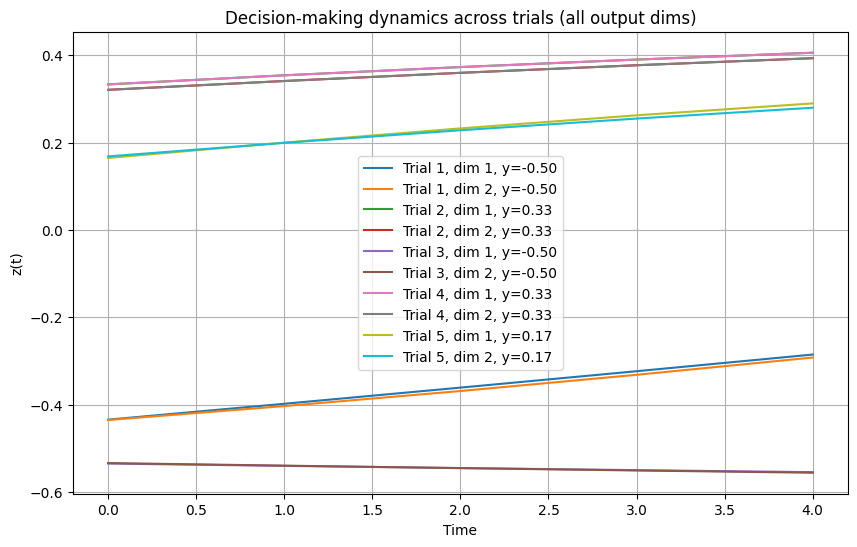

In [63]:
# test the trained model on a batch of trials
num_trials = 5
u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=num_trials)
u_batch = u_batch.to(device)
y_batch = y_batch.to(device)
z_batch = model(u_batch)  # (B, T, R)
z_decision = z_batch[:, -T_decision:, :]  # (B, T_decision, R)
y_target = y_batch.unsqueeze(1).unsqueeze(2).expand_as(z_decision)
loss = loss_fn(z_decision, y_target)
print(f"Test Loss: {loss.item():.5f}")

# Plot example trajectories for all output dims
plt.figure(figsize=(10, 6))
for i in range(num_trials):
    for r in range(z_decision.shape[2]):
        plt.plot(z_decision[i, :, r].detach().cpu().numpy(), label=f'Trial {i+1}, dim {r+1}, y={y_batch[i]:.2f}')
plt.xlabel('Time')
plt.ylabel('z(t)')
plt.title('Decision-making dynamics across trials (all output dims)')
plt.legend()
plt.grid(True)
plt.show()

## 4. Connectivity Patterns

Visualize the connectivity patterns from the trained network, and compare with those reported by Dubreuil et al. (their Figure 3b). Why do these patterns work? Why could a rank 1 network not solve this task?

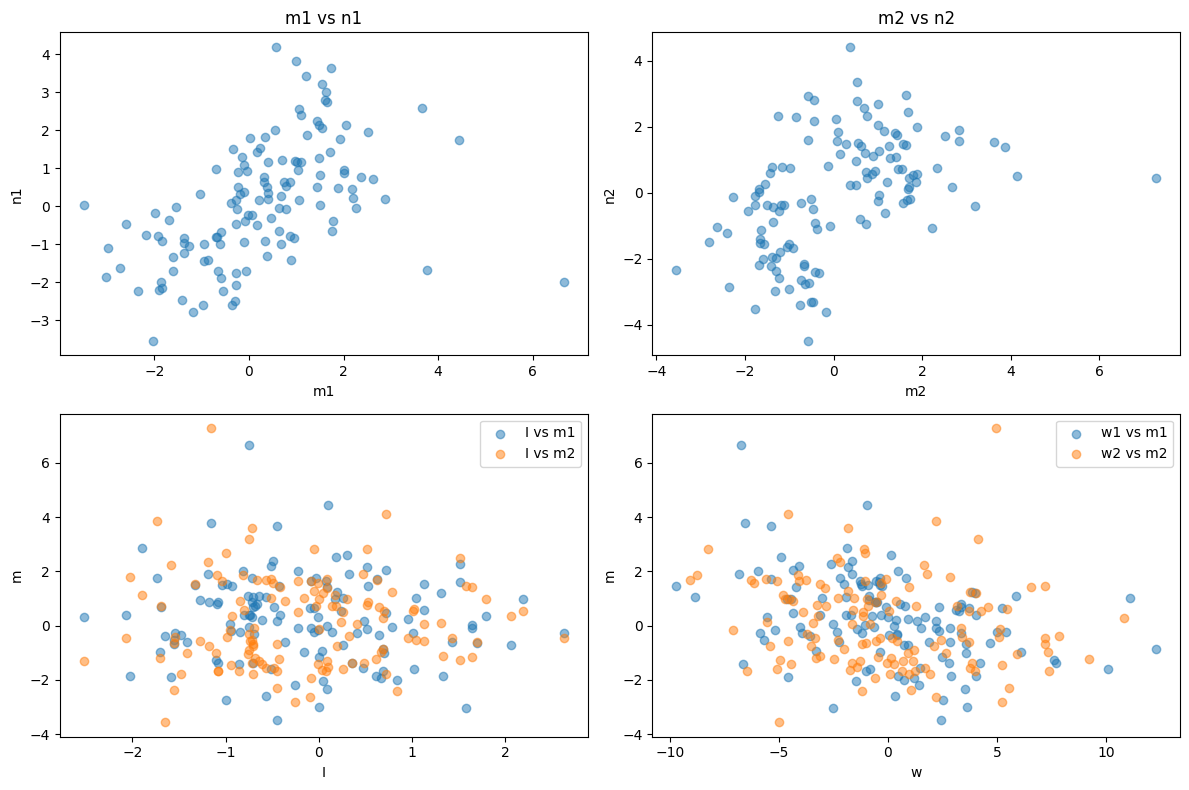

These patterns show strong correlations between specific pairs (e.g., m1-n1, m2-n2), as in Dubreuil et al. Fig 3b. This structure enables the network to store and compare two independent stimulus values, supporting parametric working memory. A rank 1 network cannot represent two independent memory traces, so it cannot solve this task.


In [65]:
import seaborn as sns

# Visualize the connectivity patterns for the trained rank-2 network

m = model.m.detach().cpu().numpy()  # shape (N, 2)
n = model.n.detach().cpu().numpy()  # shape (N, 2)
I = model.I.detach().cpu().numpy()  # shape (N,)
w = model.w.detach().cpu().numpy()  # shape (N, 2)


plt.figure(figsize=(12, 8))

# Scatter plots for each pair of connectivity vectors
plt.subplot(2, 2, 1)
plt.scatter(m[:, 0], n[:, 0], alpha=0.5)
plt.xlabel('m1')
plt.ylabel('n1')
plt.title('m1 vs n1')

plt.subplot(2, 2, 2)
plt.scatter(m[:, 1], n[:, 1], alpha=0.5)
plt.xlabel('m2')
plt.ylabel('n2')
plt.title('m2 vs n2')

plt.subplot(2, 2, 3)
plt.scatter(I, m[:, 0], alpha=0.5, label='I vs m1')
plt.scatter(I, m[:, 1], alpha=0.5, label='I vs m2')
plt.xlabel('I')
plt.ylabel('m')
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(w[:, 0], m[:, 0], alpha=0.5, label='w1 vs m1')
plt.scatter(w[:, 1], m[:, 1], alpha=0.5, label='w2 vs m2')
plt.xlabel('w')
plt.ylabel('m')
plt.legend()

plt.tight_layout()
plt.show()

print(
    "These patterns show strong correlations between specific pairs (e.g., m1-n1, m2-n2), "
    "as in Dubreuil et al. Fig 3b. This structure enables the network to store and compare "
    "two independent stimulus values, supporting parametric working memory. "
    "A rank 1 network cannot represent two independent memory traces, so it cannot solve this task."
)

## 5. Dimensionality Reduction

Project the $N$-dimensional activity onto the $m_1, m_2$ plane to obtain latent variables $\kappa_1, \kappa_2$. Does their activity show the two time scales you might expect from the connectivity patterns?

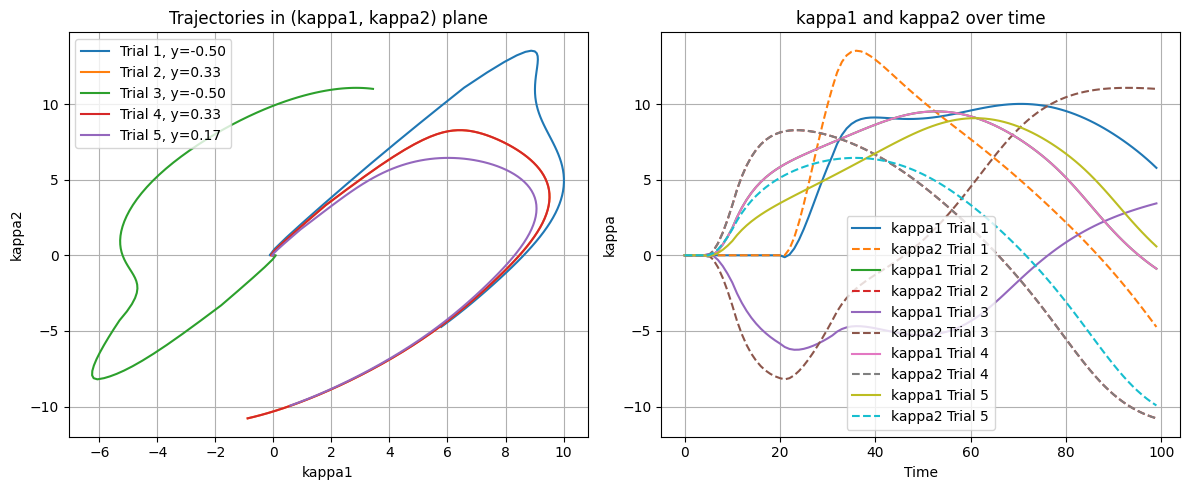

You should observe that kappa1 and kappa2 exhibit different time scales, reflecting the two-rank structure: one stores the first stimulus, the other the second. This matches the expected connectivity-driven timescales.


In [67]:
# Project the N-dimensional activity onto the m1, m2 plane to obtain kappa1, kappa2

# 1. Collect hidden states x(t) for several trials
def get_hidden_states_multirank(model, u_batch):
    B, T = u_batch.shape
    x = torch.zeros(B, model.N, device=u_batch.device)
    xs = []
    for t in range(T):
        phi_x = torch.tanh(x)
        J_phi = (1 / model.N) * (phi_x @ model.n) @ model.m.T
        u_t = u_batch[:, t].unsqueeze(1)
        du = (-x + J_phi + model.I * u_t) * (model.dt / model.tau)
        x = x + du
        xs.append(x.detach().cpu().numpy())
    xs = np.stack(xs, axis=1)  # (B, T, N)
    return xs

num_trials = 5
T_total = u_batch.shape[1] if 'u_batch' in locals() else 100
# Use the same batch as in previous cell if available, else generate new
if 'u_batch' not in locals():
    t = np.arange(0, T_total)
    u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=num_trials)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

xs = get_hidden_states_multirank(model, u_batch)  # (B, T, N)

# 2. Project onto m1 and m2
m = model.m.detach().cpu().numpy()  # (N, 2)
m1 = m[:, 0]
m2 = m[:, 1]
m1_norm = m1 / np.linalg.norm(m1)
m2_norm = m2 / np.linalg.norm(m2)

# Compute kappa1 and kappa2 for each trial and time
kappa1 = np.dot(xs, m1_norm)  # (B, T)
kappa2 = np.dot(xs, m2_norm)  # (B, T)

# 3. Plot the trajectories in the (kappa1, kappa2) plane and as time series
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(num_trials):
    plt.plot(kappa1[i], kappa2[i], label=f'Trial {i+1}, y={y_batch[i]:.2f}')
plt.xlabel('kappa1')
plt.ylabel('kappa2')
plt.title('Trajectories in (kappa1, kappa2) plane')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(num_trials):
    plt.plot(kappa1[i], label=f'kappa1 Trial {i+1}')
    plt.plot(kappa2[i], '--', label=f'kappa2 Trial {i+1}')
plt.xlabel('Time')
plt.ylabel('kappa')
plt.title('kappa1 and kappa2 over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(
    "You should observe that kappa1 and kappa2 exhibit different time scales, "
    "reflecting the two-rank structure: one stores the first stimulus, the other the second. "
    "This matches the expected connectivity-driven timescales."
)

## 6. Covariance Patterns

Test if the covariance patterns characterize the network connectivity by fitting and resampling a 6-dimensional Gaussian to the connectivity patterns.

> The (somewhat circuitous) definition of the stimuli is meant to evoke the working memory task developed by Romo et al. [7] in which subjects have to compare vibrotactile stimuli of different frequencies.

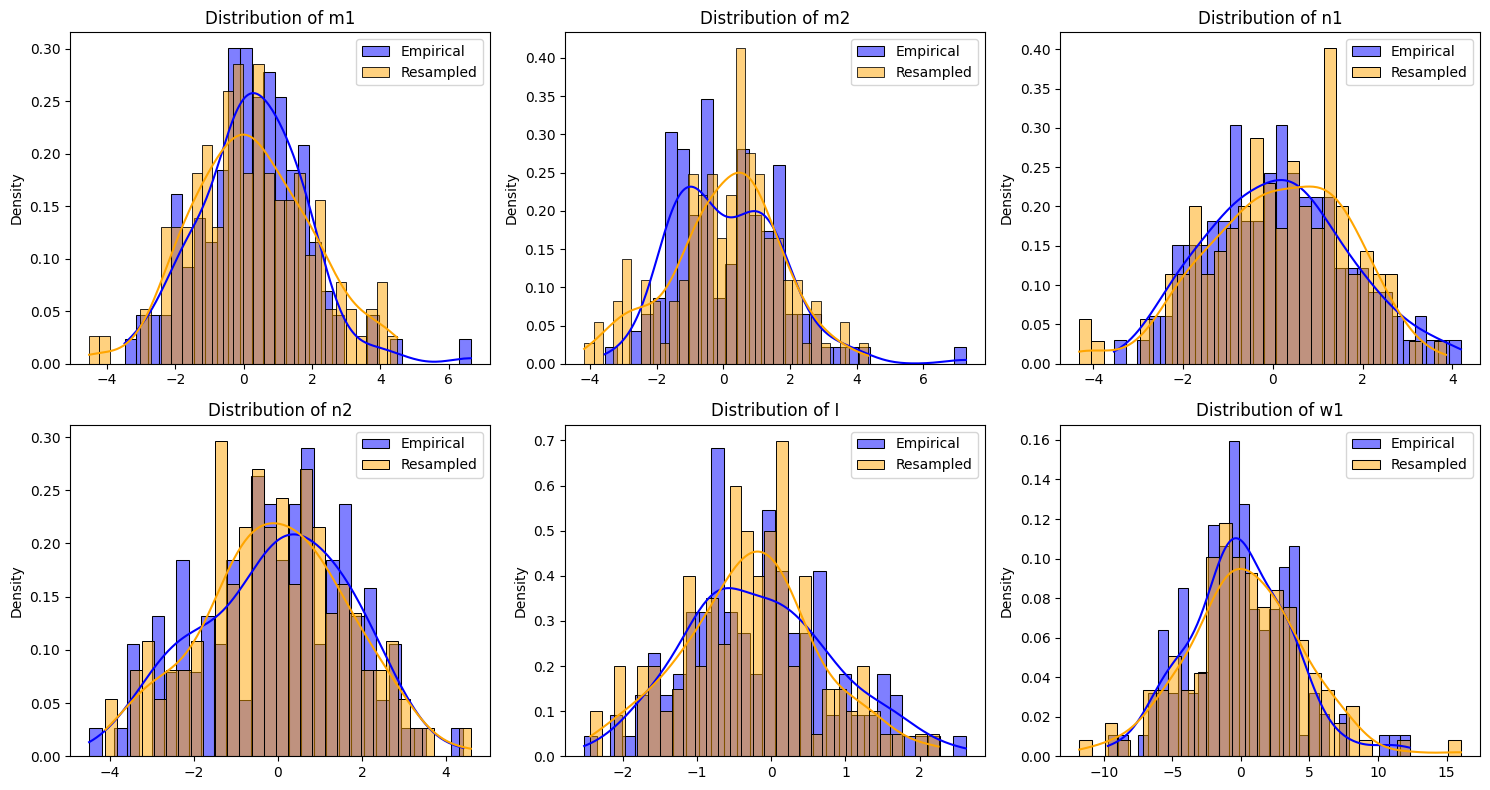

Test MSE (resampled connectivity): 0.39471


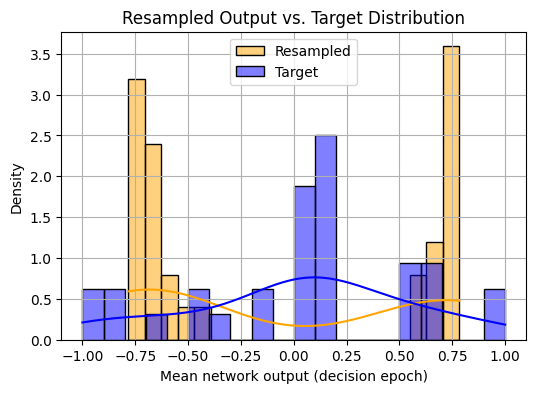

In [69]:
import seaborn as sns

# 1. Stack all relevant connectivity vectors into a (N, 6) matrix
m = model.m.detach().cpu().numpy()      # (N, 2)
n = model.n.detach().cpu().numpy()      # (N, 2)
I = model.I.detach().cpu().numpy()      # (N,)
w = model.w.detach().cpu().numpy()      # (N, 2)

X = np.column_stack([m, n, I, w])       # (N, 7) but we want (N, 6): m1, m2, n1, n2, I, w1

# We'll use only one output weight (w1) for simplicity, or both if desired
X = np.column_stack([m[:,0], m[:,1], n[:,0], n[:,1], I, w[:,0]])  # (N, 6)
param_names = ['m1', 'm2', 'n1', 'n2', 'I', 'w1']

# 2. Fit a 6D Gaussian: estimate mean and covariance
mean = X.mean(axis=0)
cov = np.cov(X, rowvar=False)

# 3. Resample from the fitted Gaussian
N = X.shape[0]
X_resampled = np.random.multivariate_normal(mean, cov, size=N)

# 4. Compare empirical and resampled distributions
plt.figure(figsize=(15, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 3, i+1)
    sns.histplot(X[:, i], color='blue', label='Empirical', kde=True, stat='density', bins=30)
    sns.histplot(X_resampled[:, i], color='orange', label='Resampled', kde=True, stat='density', bins=30, alpha=0.5)
    plt.title(f'Distribution of {name}')
    plt.legend()
plt.tight_layout()
plt.show()

# 5. Test a new network with resampled connectivity
model_gauss = MultiRankRNN(N=N, num_ranks=2).to(device)
with torch.no_grad():
    model_gauss.m.copy_(torch.tensor(X_resampled[:, :2], dtype=torch.float32, device=device))
    model_gauss.n.copy_(torch.tensor(X_resampled[:, 2:4], dtype=torch.float32, device=device))
    model_gauss.I.copy_(torch.tensor(X_resampled[:, 4], dtype=torch.float32, device=device))
    model_gauss.w.copy_(torch.tensor(np.column_stack([X_resampled[:, 5], np.zeros(N)]), dtype=torch.float32, device=device))

# Use a batch of trials to test
u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=32)
u_batch = u_batch.to(device)
y_batch = y_batch.to(device)
with torch.no_grad():
    z_batch_gauss = model_gauss(u_batch)  # (B, T, 2)
    z_decision_gauss = z_batch_gauss[:, -5:, 0]  # (B, 5)
    mean_z_gauss = z_decision_gauss.mean(dim=1).cpu().numpy()
    y_np = y_batch.cpu().numpy()
    # For this task, output should match the sign and value of y
    mse = np.mean((mean_z_gauss - y_np) ** 2)
    print(f"Test MSE (resampled connectivity): {mse:.5f}")

# Plot output comparison
plt.figure(figsize=(6, 4))
sns.histplot(mean_z_gauss, color='orange', label='Resampled', kde=True, stat='density', bins=20)
sns.histplot(y_np, color='blue', label='Target', kde=True, stat='density', bins=20, alpha=0.5)
plt.xlabel('Mean network output (decision epoch)')
plt.title('Resampled Output vs. Target Distribution')
plt.legend()
plt.grid(True)
plt.show()

## 7. Two-Dimensional Equivalent Circuit

Under the appropriate assumptions, the trained network can now be described by a two-dimensional equivalent circuit. Its dynamics are given by

$$
\frac{d\kappa_1}{dt} = -\kappa_1 + \tilde{\sigma}_{m_1 n_1} \kappa_1 + \tilde{\sigma}_{n_1 I} v(t)
$$

$$
\frac{d\kappa_2}{dt} = -\kappa_2 + \tilde{\sigma}_{m_2 n_2} \kappa_2 + \tilde{\sigma}_{n_2 I} v(t)
$$

The coupling terms again encapsulate the system’s nonlinearity, here via the scaling

$$
\Delta = \sqrt{\sigma_{m_1}^2 \kappa_1^2 + \sigma_{m_2}^2 \kappa_2^2 + \sigma_I^2 v^2}
$$

Simulate the effective circuit for different inputs $v$. The circuit should perform qualitatively, but not necessarily quantitatively, the same as the full network. If it does not, try using the covariances reported in the paper: $\sigma_{n_1 m_1} = 1$, $\sigma_{n_2 m_2} = 0.5$, $\sigma_{n_1 I} = 0.5$, $\sigma_{n_2 I} = 1.9$, $\sigma_{m_1 w} = 2.8$, $\sigma_{m_2 w} = -2.2$.

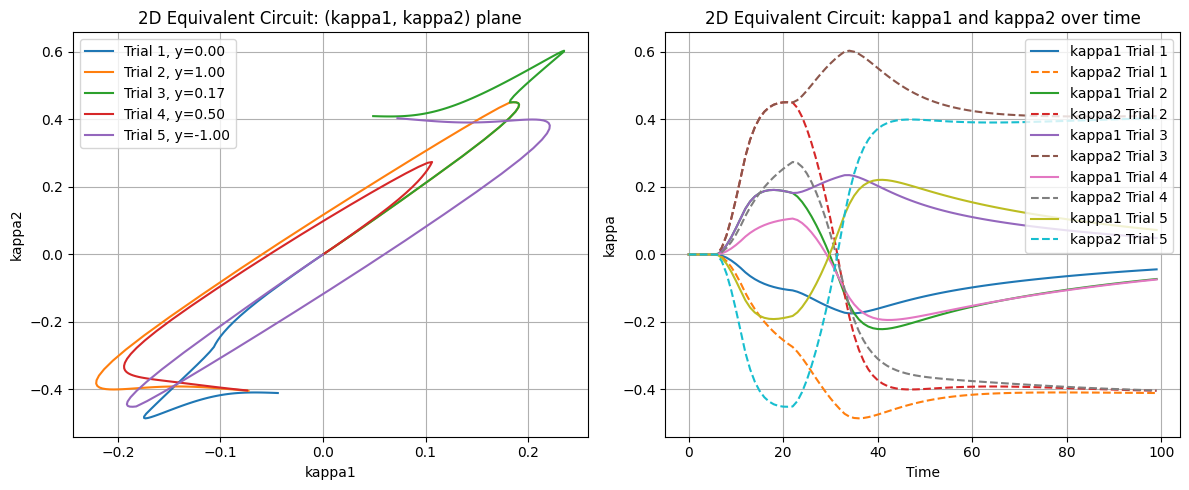

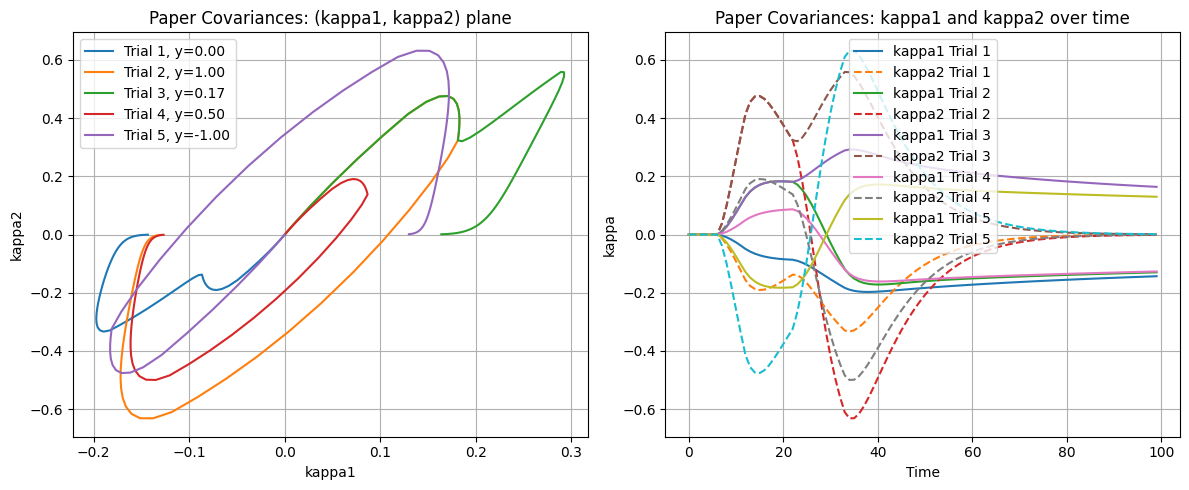

In [71]:
from scipy import integrate

# 1. Compute empirical covariances from the trained network
m = model.m.detach().cpu().numpy()      # (N, 2)
n = model.n.detach().cpu().numpy()      # (N, 2)
I = model.I.detach().cpu().numpy()      # (N,)

sigma_m1 = np.std(m[:, 0])
sigma_m2 = np.std(m[:, 1])
sigma_n1 = np.std(n[:, 0])
sigma_n2 = np.std(n[:, 1])
sigma_I = np.std(I)

sigma_m1n1 = np.cov(m[:, 0], n[:, 0])[0, 1]
sigma_m2n2 = np.cov(m[:, 1], n[:, 1])[0, 1]
sigma_n1I = np.cov(n[:, 0], I)[0, 1]
sigma_n2I = np.cov(n[:, 1], I)[0, 1]

# 2. Define <phi'> as a function of Delta
def phi_prime(z):
    return 1 - np.tanh(z)**2

def mean_phi_prime(Delta):
    integrand = lambda z: phi_prime(Delta * z) * np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)
    val, _ = integrate.quad(integrand, -8, 8)
    return val

# 3. Simulate the 2D equivalent circuit
def simulate_2d_equiv(u, dt=20, tau=100, kappa0=(0,0), v0=0,
                      sigma_m1n1=None, sigma_m2n2=None, sigma_n1I=None, sigma_n2I=None,
                      sigma_m1=None, sigma_m2=None, sigma_I=None):
    T = len(u)
    kappa1 = np.zeros(T)
    kappa2 = np.zeros(T)
    v = np.zeros(T)
    kappa1[0], kappa2[0] = kappa0
    v[0] = v0
    for t in range(1, T):
        dv = (-v[t-1] + u[t-1]) * (dt / tau)
        v[t] = v[t-1] + dv

        Delta = np.sqrt((sigma_m1**2) * kappa1[t-1]**2 + (sigma_m2**2) * kappa2[t-1]**2 + (sigma_I**2) * v[t-1]**2)
        gain = mean_phi_prime(Delta)

        sm1n1_eff = sigma_m1n1 * gain
        sm2n2_eff = sigma_m2n2 * gain
        sn1I_eff = sigma_n1I * gain
        sn2I_eff = sigma_n2I * gain

        dkappa1 = (-kappa1[t-1] + sm1n1_eff * kappa1[t-1] + sn1I_eff * v[t-1]) * (dt / tau)
        dkappa2 = (-kappa2[t-1] + sm2n2_eff * kappa2[t-1] + sn2I_eff * v[t-1]) * (dt / tau)
        kappa1[t] = kappa1[t-1] + dkappa1
        kappa2[t] = kappa2[t-1] + dkappa2
    return kappa1, kappa2, v

# 4. Run the simulation for a batch of trials and compare with the full network
num_trials = 5
T_total = z_batch.shape[1]
if 'u_batch' not in locals():
    t = np.arange(0, T_total)
    u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=num_trials)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)
else:
    t = np.arange(0, u_batch.shape[1])

u_batch_np = u_batch.cpu().numpy()

kappa1_all = []
kappa2_all = []
for i in range(num_trials):
    k1, k2, v = simulate_2d_equiv(
        u_batch_np[i],
        sigma_m1n1=sigma_m1n1, sigma_m2n2=sigma_m2n2,
        sigma_n1I=sigma_n1I, sigma_n2I=sigma_n2I,
        sigma_m1=sigma_m1, sigma_m2=sigma_m2, sigma_I=sigma_I
    )
    kappa1_all.append(k1)
    kappa2_all.append(k2)
kappa1_all = np.stack(kappa1_all)
kappa2_all = np.stack(kappa2_all)

# 5. Plot the trajectories in the (kappa1, kappa2) plane and as time series
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(num_trials):
    plt.plot(kappa1_all[i], kappa2_all[i], label=f'Trial {i+1}, y={y_batch[i]:.2f}')
plt.xlabel('kappa1')
plt.ylabel('kappa2')
plt.title('2D Equivalent Circuit: (kappa1, kappa2) plane')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(num_trials):
    plt.plot(kappa1_all[i], label=f'kappa1 Trial {i+1}')
    plt.plot(kappa2_all[i], '--', label=f'kappa2 Trial {i+1}')
plt.xlabel('Time')
plt.ylabel('kappa')
plt.title('2D Equivalent Circuit: kappa1 and kappa2 over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. If the above does not perform well, try the paper's reported covariances
# Paper: sigma_{n1m1}=1, sigma_{n2m2}=0.5, sigma_{n1I}=0.5, sigma_{n2I}=1.9, sigma_{m1}=sigma_{m2}=sigma_I=1
kappa1_paper = []
kappa2_paper = []
for i in range(num_trials):
    k1, k2, v = simulate_2d_equiv(
        u_batch_np[i],
        sigma_m1n1=1.0, sigma_m2n2=0.5,
        sigma_n1I=0.5, sigma_n2I=1.9,
        sigma_m1=1.0, sigma_m2=1.0, sigma_I=1.0
    )
    kappa1_paper.append(k1)
    kappa2_paper.append(k2)
kappa1_paper = np.stack(kappa1_paper)
kappa2_paper = np.stack(kappa2_paper)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(num_trials):
    plt.plot(kappa1_paper[i], kappa2_paper[i], label=f'Trial {i+1}, y={y_batch[i]:.2f}')
plt.xlabel('kappa1')
plt.ylabel('kappa2')
plt.title('Paper Covariances: (kappa1, kappa2) plane')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(num_trials):
    plt.plot(kappa1_paper[i], label=f'kappa1 Trial {i+1}')
    plt.plot(kappa2_paper[i], '--', label=f'kappa2 Trial {i+1}')
plt.xlabel('Time')
plt.ylabel('kappa')
plt.title('Paper Covariances: kappa1 and kappa2 over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()